In [30]:
import matplotlib.pyplot as plt

import mapel.elections as mapel
from scripts.gurobi import gurobi_ilp

import scripts.experiments as experiments
import os

import numpy as np

import pickle
from scripts.basin_hopping import basin_hopping
from scripts.approvalwise_vector import get_approvalwise_vectors
from matplotlib import ticker


plt.rcParams['figure.dpi'] = 140

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [60]:
def compare(reference_new_approvalwise_vectors, approvalwise_vectors, num_voters, num_generated, generator, experiment_id, id_scheme):
    reports = []
    new_approvalwise_vectorss = []

    for num_starting_elections in range(len(reference_new_approvalwise_vectors)):
        starting_approvalwise_vectors = [reference_new_approvalwise_vectors[id_scheme % i] for i in range(num_starting_elections)]
        new_approvalwise_vectors, report = experiments.generate_farthest_elections_l1_approvalwise(
            approvalwise_vectors + starting_approvalwise_vectors, num_voters, num_generated - num_starting_elections, generator, experiment_id)
        new_approvalwise_vectorss.append(new_approvalwise_vectors)
        reports.append(report)
    return reports, new_approvalwise_vectorss

def calculate_cumulative_proportional_vector(reference_distances: list[int], distancess: list[list[int]]) -> np.ndarray:
    distances_sums = [np.sum(distances) for distances in distancess]
    reference_distances  = np.array(reference_distances)
    reference_distances_sums = np.cumsum(reference_distances[::-1])[::-1]
    return distances_sums / reference_distances_sums

def plot_trajectories(reference_report, reports):

    plt.scatter(reference_report.experiment_size , reference_report.distance, label = "Gurobi")
    plt.plot(reference_report.experiment_size, reference_report.distance, '--')

    for idx, report in enumerate(reports):
        plt.scatter(report.experiment_size, report.distance, label=f'From {idx} gurobi elections')
        plt.plot(report.experiment_size, report.distance, '--')
        
    plt.legend()
    

def plot_metric(reference_report, reports):
    res = calculate_cumulative_proportional_vector(reference_report.distance, [report.distance for report in reports])
    fig, ax = plt.subplots()

    ax.bar(np.arange(len(res)), res)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
    ax.set_ylim(0, 1)
    return fig, ax
        
    

# Content

In [39]:
num_generated = 12
num_candidates = 50
num_voters = 100
family_id = 'euclidean'
solver_id = 'gurobi'

experiment_id = f'{num_candidates}x{num_voters}/{family_id}'

with open(os.path.join('results', solver_id, experiment_id, 'new-approvalwise-vectors.pkl'), 'rb') as f:
    gurobi_new_approvalwise_vectors = pickle.load(f) 

with open(os.path.join('results', solver_id, experiment_id, 'report.pkl'), 'rb') as f:
    gurobi_report = pickle.load(f) 


In [36]:
len(gurobi_new_approvalwise_vectors)

3

In [49]:



experiment = mapel.prepare_offline_approval_experiment(
    experiment_id=experiment_id,
    distance_id="l1-approvalwise",
    embedding_id="fr"
)
experiment.prepare_elections()

id_scheme = f'NFE-{experiment_id}-%d'


meaningful_elections = experiments.get_meaningful_elections_from_experiment(experiment)
approvalwise_vectors = get_approvalwise_vectors(meaningful_elections)

niter=3906


Preparing instances: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


In [45]:
gurobi_new_approvalwise_vectors.values()

dict_values([[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 5, 5, 2, 0]])

In [53]:
import pandas as pd
from scripts.basin_hopping import __distance_across

gurobi_distances = [__distance_across(approvalwise_vectors, np.array(x)) for x in gurobi_new_approvalwise_vectors.values()]
gurobi_experiment_sizes = list(range(200, 200 + len(gurobi_new_approvalwise_vectors)))
gurobi_report = pd.DataFrame({
        'experiment_size': gurobi_experiment_sizes,
        'distance': gurobi_distances
    })

gurobi_report

,experiment_size,distance
0,200,1748.0
1,201,1320.0
2,202,1015.0


In [55]:
from scripts.approvalwise_vector import dump_to_text_file

with open(os.path.join('results', solver_id, f'{num_candidates}x{num_voters}', 'approvalwise-vectors.txt'), 'w') as file:
    dump_to_text_file(approvalwise_vectors, num_voters, file)
    
with open(os.path.join('results', solver_id, experiment_id, 'new-approvalwise-vectors.txt'), 'w') as file:
    dump_to_text_file(gurobi_new_approvalwise_vectors, num_voters, file)


# Basin hopping step_vector

In [ ]:
generator = lambda approvalwise_vectors, num_voters: basin_hopping(
    approvalwise_vectors=approvalwise_vectors, 
    num_voters=num_voters, 
    step_size=7,  
    seed=2137, 
    big_step_chance=0.2,
    x0='step_vector'
)

reports, new_approvalwise_vectorss = compare(gurobi_new_approvalwise_vectors, approvalwise_vectors, num_voters, num_generated, generator, experiment_id, id_scheme)

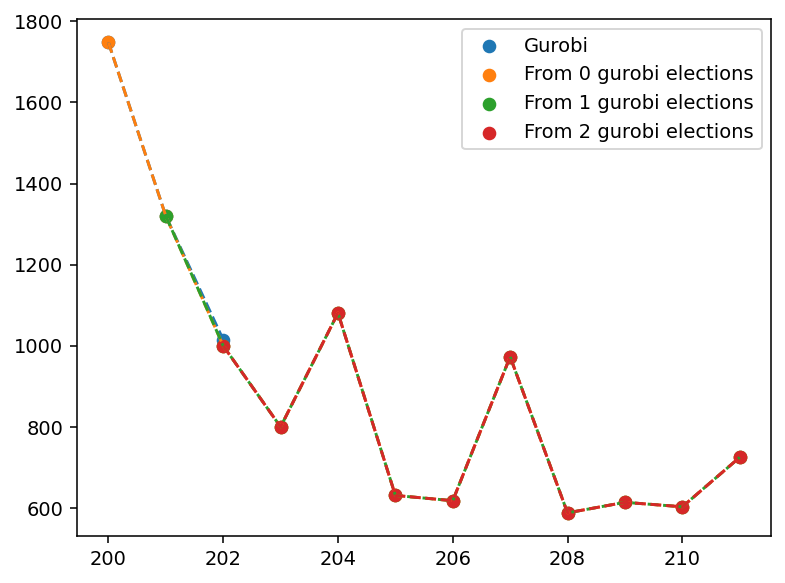

In [58]:
plot_trajectories(gurobi_report, reports)

(<Figure size 896x672 with 1 Axes>, <Axes: >)

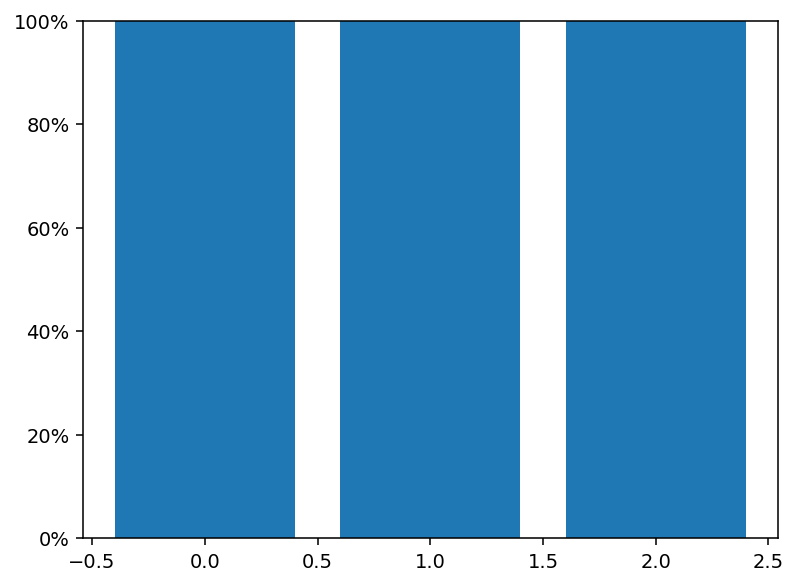

In [59]:
plot_metric(gurobi_report, reports)

# Basin hopping random

In [ ]:
generator = lambda approvalwise_vectors, num_voters: basin_hopping(
    approvalwise_vectors=approvalwise_vectors, 
    num_voters=num_voters, 
    step_size=7,  
    seed=2137, 
    big_step_chance=0.2,
    x0='step_vector'
)

reports, new_approvalwise_vectorss = compare(gurobi_new_approvalwise_vectors, approvalwise_vectors, num_voters, num_generated, generator, experiment_id, id_scheme)

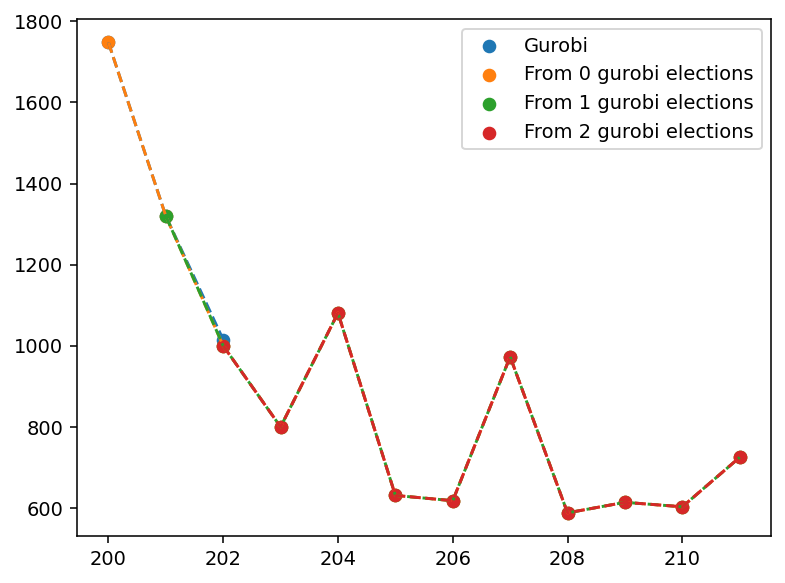

In [ ]:
plot_trajectories(gurobi_report, reports)

(<Figure size 896x672 with 1 Axes>, <Axes: >)

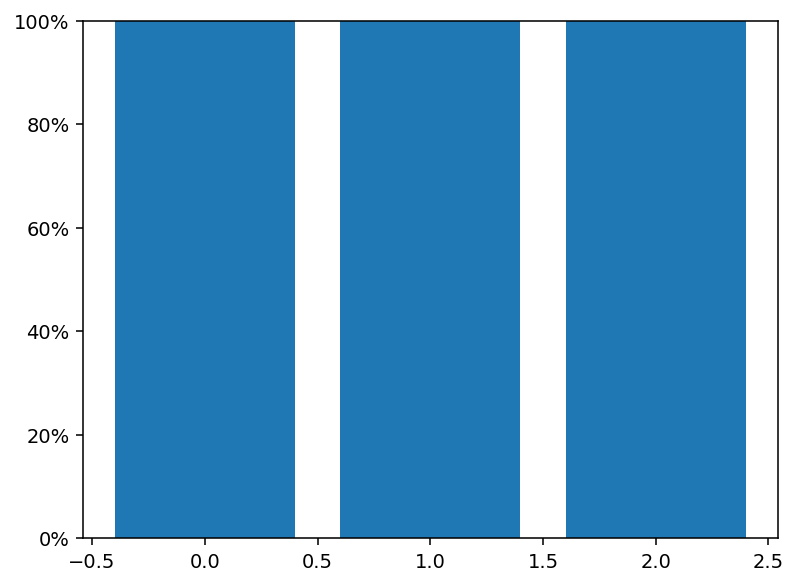

In [ ]:
plot_metric(gurobi_report, reports)

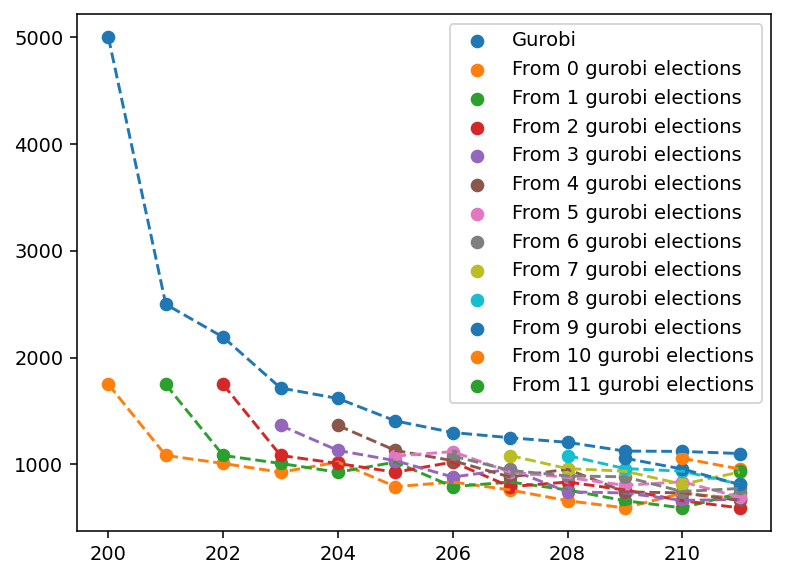

In [38]:
plt.scatter(gurobi_report.experiment_size - 241, gurobi_report.distance, label = "Gurobi")
plt.plot(gurobi_report.experiment_size - 241, gurobi_report.distance, '--')

for idx, report in enumerate(reports):
    plt.scatter(report.experiment_size, report.distance, label=f'From {idx} gurobi elections')
    plt.plot(report.experiment_size, report.distance, '--')
    
plt.legend()

(0.0, 1.0)

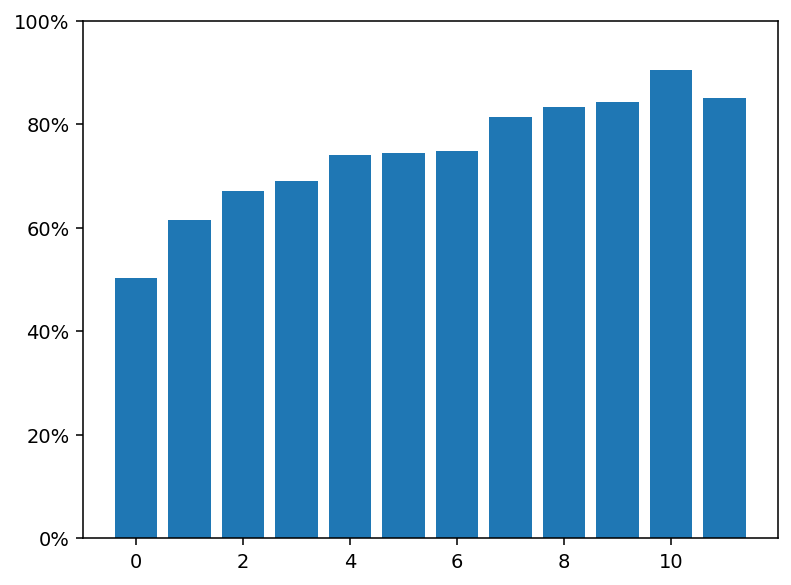

In [37]:
from matplotlib import ticker

res = calculate_cumulative_proportional_vector(gurobi_report.distance, [report.distance for report in reports])

fig, ax = plt.subplots()

ax.bar(np.arange(len(res)), res)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_ylim(0, 1)

(0.0, 1.0)

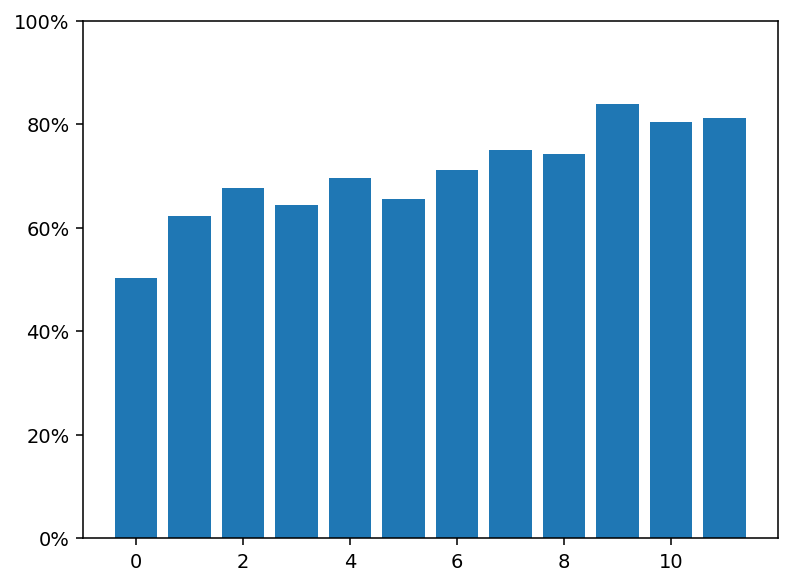

In [8]:
from matplotlib import ticker

res = calculate_cumulative_proportional_vector(gurobi_report.distance, [report.distance for report in reports])

fig, ax = plt.subplots()

ax.bar(np.arange(len(res)), res)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_ylim(0, 1)

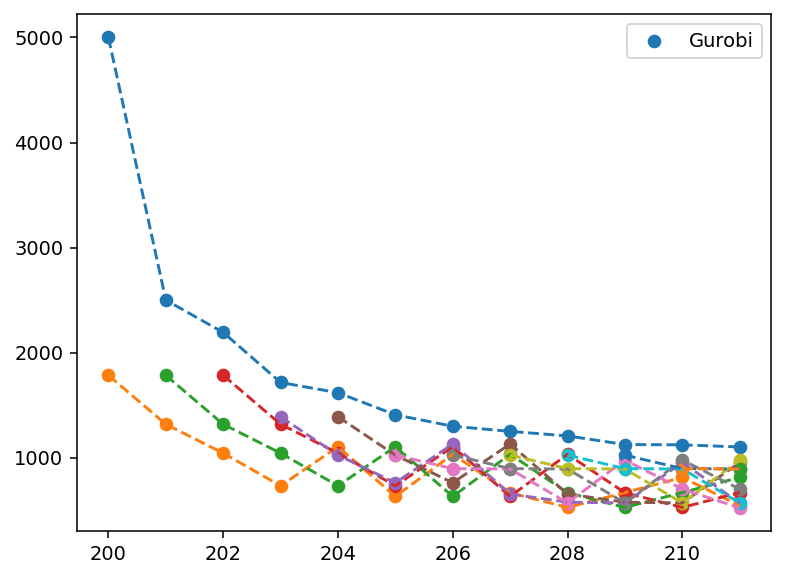

In [7]:
plt.scatter(gurobi_report.experiment_size - 241, gurobi_report.distance, label = "Gurobi")
plt.plot(gurobi_report.experiment_size - 241, gurobi_report.distance, '--')

for report in reports:
    plt.scatter(report.experiment_size, report.distance)
    plt.plot(report.experiment_size, report.distance, '--')
    
plt.legend()


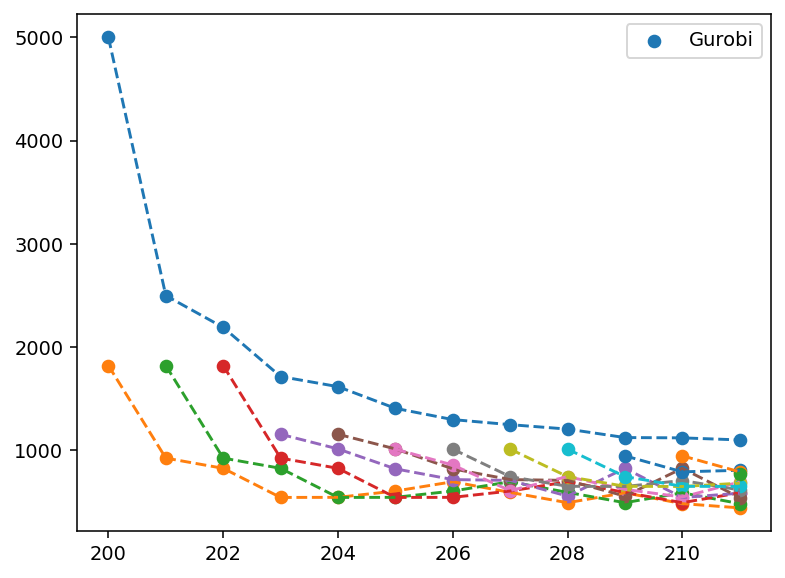

In [20]:

plt.scatter(gurobi_report.experiment_size - 241, gurobi_report.distance, label = "Gurobi")
plt.plot(gurobi_report.experiment_size - 241, gurobi_report.distance, '--')

for report in reports:
    plt.scatter(report.experiment_size, report.distance)
    plt.plot(report.experiment_size, report.distance, '--')
    
plt.legend()


In [3]:
generator = gurobi_ilp

experiments_results = {}
reports = {}
new_approval_vectors_per_experiment = {}

# Approval experiments

## Euclidean culture

Preparing instances: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


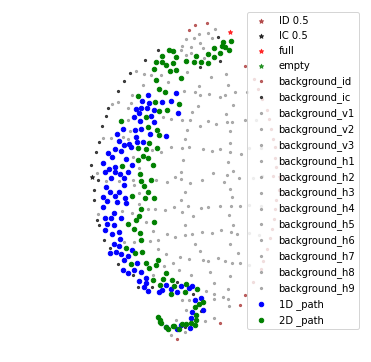

  0%|          | 0/12 [00:00<?, ?it/s]

In [9]:
experiment_id = 'euclidean'

num_generated = 12

num_candidates = 50
num_voters = 100

experiment_id = f'{num_candidates}x{num_voters}/{experiment_id}'

experiment = mapel.prepare_offline_approval_experiment(
    experiment_id=experiment_id,
    distance_id="l1-approvalwise",
    embedding_id="fr"
)
experiment.prepare_elections()
experiment.print_map_2d()

family_dirpath = os.path.join('results', 'gurobi', experiment_id)
if not os.path.exists(family_dirpath):
    os.makedirs(family_dirpath)
new_approvalwise_vectors, report = experiments.generate_farthest_elections_l1_approvalwise(
    experiment, num_generated, generator, experiment_id, save_snapshots=family_dirpath)
experiments.plot_report(report)

experiments_results[experiment_id] = experiment
reports[experiment_id] = report
new_approval_vectors_per_experiment[experiment_id] = new_approvalwise_vectors

experiment.compute_distances(distance_id='l1-approvalwise')
experiment.embed_2d(embedding_id="fr")
experiment.print_map_2d()

# Noise resampling culture

Preparing instances: 100%|██████████| 27/27 [00:03<00:00,  7.58it/s]


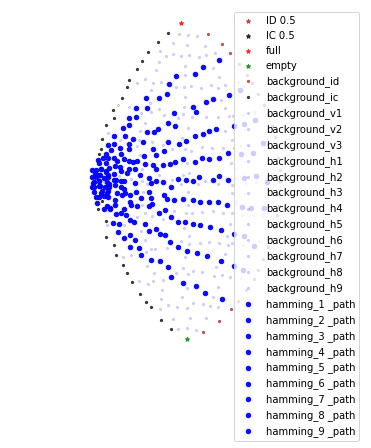

  0%|          | 0/12 [00:00<?, ?it/s]

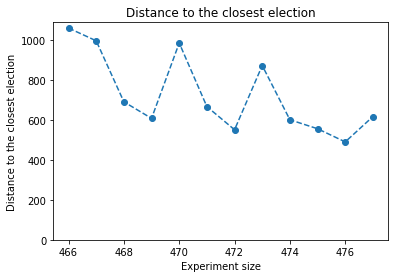

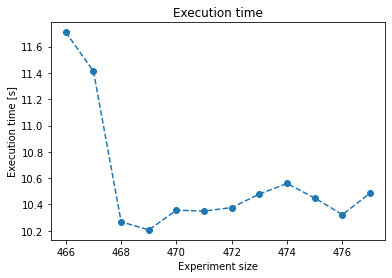

In [ ]:
experiment_id = 'noise'

num_generated = 12

num_candidates = 50
num_voters = 100

experiment_id = f'{num_candidates}x{num_voters}/{experiment_id}'

experiment = experiment_50_100 = mapel.prepare_offline_approval_experiment(
    experiment_id=experiment_id,
    distance_id="l1-approvalwise",
    embedding_id="fr"
)
experiment.prepare_elections()

experiment.print_map_2d()

family_dirpath = os.path.join('results', 'gurobi', experiment_id)
if not os.path.exists(family_dirpath):
    os.makedirs(family_dirpath)
new_approvalwise_vectors, report = experiments.generate_farthest_elections_l1_approvalwise(
    experiment, num_generated, generator, experiment_id, save_snapshots=family_dirpath)

experiments.plot_report(report)

experiments_results[experiment_id] = experiment
reports[experiment_id] = report
new_approval_vectors_per_experiment[experiment_id] = new_approvalwise_vectors

experiment.compute_distances(distance_id='l1-approvalwise')
experiment.embed_2d(embedding_id="fr")
experiment.print_map_2d()

Computing distances: 100%|██████████| 114003/114003 [02:04<00:00, 917.09it/s]


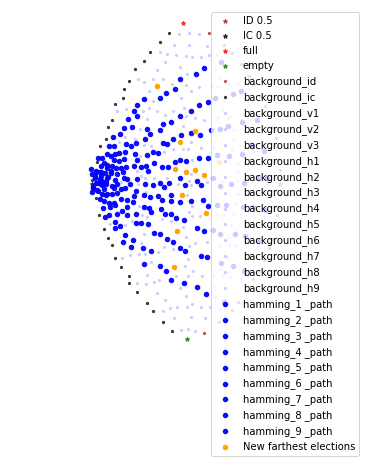

# Truncated urn culture

Preparing instances: 100%|██████████| 27/27 [00:01<00:00, 19.30it/s]


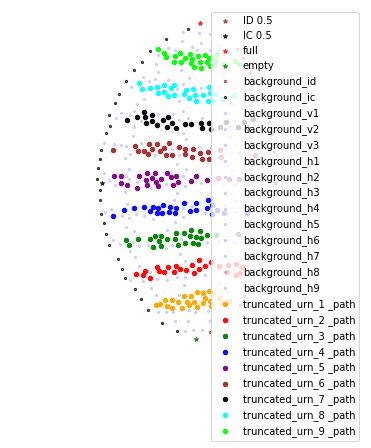

  0%|          | 0/12 [00:00<?, ?it/s]

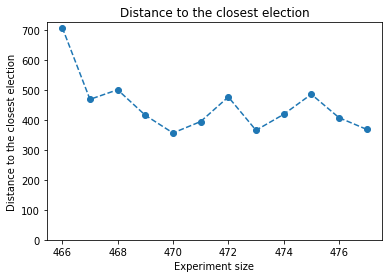

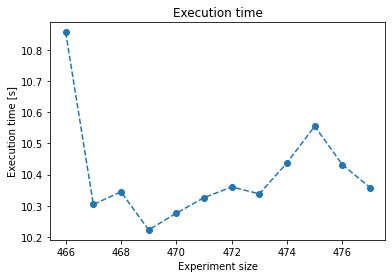

Computing distances: 100%|██████████| 114003/114003 [02:00<00:00, 949.75it/s] 


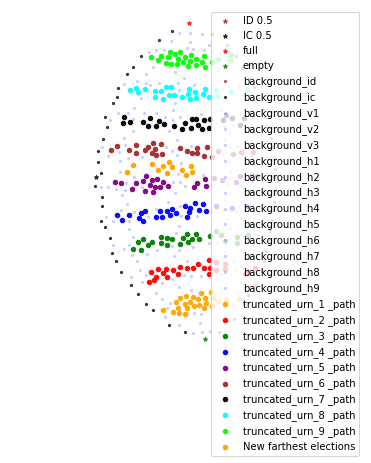

In [23]:
experiment_id = 'truncated_urn'

num_generated = 12

num_candidates = 50
num_voters = 100

experiment = mapel.prepare_offline_approval_experiment(
    experiment_id=f'{num_candidates}x{num_voters}/{experiment_id}',
    distance_id="l1-approvalwise",
    embedding_id="fr"
)
experiment.prepare_elections()

experiment.print_map_2d()


family_dirpath = os.path.join('results', 'gurobi', experiment_id)
if not os.path.exists(family_dirpath):
    os.makedirs(family_dirpath)
new_approvalwise_vectors, report = experiments.generate_farthest_elections_l1_approvalwise(
    experiment, num_generated, generator, experiment_id, save_snapshots=family_dirpath)

experiments.plot_report(report)

experiments_results[experiment_id] = experiment
reports[experiment_id] = report
new_approval_vectors_per_experiment[experiment_id] = new_approvalwise_vectors

experiment.compute_distances(distance_id='l1-approvalwise')
experiment.embed_2d(embedding_id="fr")
experiment.print_map_2d()